In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,32,LAL,82,-10,38.3,10.2,16.9,...,7,2,1,0.732,82,2,1.000,147,0.665,221
1,2,Tom Abernethy,PF,25,GSW,67,-10,18.2,2.3,4.7,...,32,54,41,0.293,82,44,0.817,0,0.000,221
2,3,Alvan Adams,C,25,PHO,75,-10,28.9,6.2,11.7,...,11,12,12,0.671,82,6,0.915,0,0.000,221
3,4,Tiny Archibald,PG,31,BOS,80,80,35.8,4.8,9.9,...,33,31,20,0.744,82,1,0.976,2,0.009,221
4,5,Dennis Awtrey,C,31,CHI,26,-10,21.5,1.0,2.3,...,21,56,42,0.366,82,38,0.317,0,0.000,221


In [5]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [9]:
len(df[df.index.get_level_values(1) > 2015]) / len(df)

0.17507805847289243

In [10]:
val_df = df[df.index.get_level_values(1) > 2015]
dev_df = df[df.index.get_level_values(1) <= 2015]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'smote', sampling_strategy = .5)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [14]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [15]:
pipe_scale = Pipeline(steps = [
    ('Scaler', scaler),
    ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
])

In [16]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [27]:
mlflow.set_experiment('NBA MVP prediction Decision Tree')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/3', experiment_id='3', lifecycle_stage='active', name='NBA MVP prediction Decision Tree', tags={}>

In [28]:
param_grid = {
    'max_depth': [7, 8], 
    'min_samples_split': [10, 8],
    'max_features': [.6]
    }

In [29]:
with mlflow.start_run():
    estimator = DecisionTreeRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_dt(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   7.9s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   4.0s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   3.0s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   4.1s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   3.3s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   4.4s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   4.5s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   3.7s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   2.4s
[CV] END max_depth=7, max_features=0.6, min_samples_split=10; total time=   2.0s
[CV] END .max_depth=7, max_features=0.6, min_samples_split=8; total time=   2.5s
[CV] END .max_depth=7, max_features=0.6, min_sam

2022/07/31 19:29:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpmmrk59zh\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [30]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.042819,0.043308,0.041273
R2,0.913682,0.847879,0.468023


In [31]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

In [32]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.823172
263,2016,Kawhi Leonard,0.484,0.083442
222,2016,LeBron James,0.482,0.497587
452,2016,Russell Westbrook,0.371,0.097367
126,2016,Kevin Durant,0.112,0.222249
348,2016,Chris Paul,0.082,0.029203
167,2016,Draymond Green,0.038,0.021368
266,2016,Damian Lillard,0.020,0.029203
178,2016,James Harden,0.007,0.068770


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.280063
173,2017,James Harden,0.746,0.383208
261,2017,Kawhi Leonard,0.495,0.155884
221,2017,LeBron James,0.330,0.198892
425,2017,Isaiah Thomas,0.080,0.099339
98,2017,Stephen Curry,0.051,0.083442
16,2017,Giannis Antetokounmpo,0.007,0.029203
453,2017,John Wall,0.007,0.068770
100,2017,Anthony Davis,0.002,0.099339


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.562266
249,2018,LeBron James,0.731,0.383208
122,2018,Anthony Davis,0.441,0.062931
298,2018,Damian Lillard,0.205,0.029203
508,2018,Russell Westbrook,0.075,0.347591
16,2018,Giannis Antetokounmpo,0.074,0.143423
143,2018,Kevin Durant,0.065,0.083442
130,2018,DeMar DeRozan,0.032,0.028651
7,2018,LaMarcus Aldridge,0.006,0.056157


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.500150
207,2019,James Harden,0.768,0.524052
184,2019,Paul George,0.352,0.029203
270,2019,Nikola Jokić,0.210,0.021368
124,2019,Stephen Curry,0.173,0.083442
305,2019,Damian Lillard,0.068,0.083442
155,2019,Joel Embiid,0.049,0.028651
150,2019,Kevin Durant,0.025,0.083442
301,2019,Kawhi Leonard,0.013,0.083442


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.497587
251,2020,LeBron James,0.746,0.195271
199,2020,James Harden,0.363,0.427010
134,2020,Luka Dončić,0.198,0.198892
294,2020,Kawhi Leonard,0.166,0.083442
123,2020,Anthony Davis,0.081,0.155884
396,2020,Chris Paul,0.026,0.056157
297,2020,Damian Lillard,0.023,0.029203
262,2020,Nikola Jokić,0.018,0.021368


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.097367
146,2021,Joel Embiid,0.580,0.151248
116,2021,Stephen Curry,0.449,0.629605
12,2021,Giannis Antetokounmpo,0.345,0.099339
396,2021,Chris Paul,0.138,0.056157
130,2021,Luka Dončić,0.042,0.068770
297,2021,Damian Lillard,0.038,0.029203
421,2021,Julius Randle,0.020,0.006531
439,2021,Derrick Rose,0.010,0.000027


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2016,Quincy Acy,0.0,0.000027
2,2016,Jordan Adams,0.0,0.000027
3,2016,Steven Adams,0.0,0.000027
4,2016,Arron Afflalo,0.0,0.000027
5,2016,Alexis Ajinça,0.0,0.000027
...,...,...,...,...
536,2021,Delon Wright,0.0,0.002000
537,2021,Thaddeus Young,0.0,0.002000
538,2021,Trae Young,0.0,0.028651


In [33]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
66,2017,Jimmy Butler,0.0,0.222249
484,2018,Karl-Anthony Towns,0.0,0.493544
515,2019,Lou Williams,0.0,0.228554
525,2020,Trae Young,0.0,0.301022
84,2021,Jimmy Butler,0.0,0.220511


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Linear coefficient'>

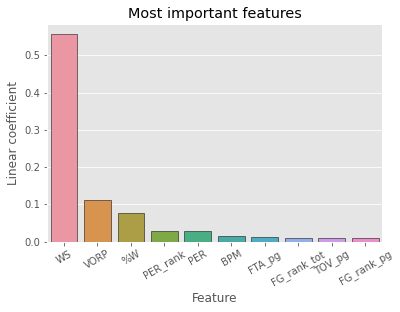

In [34]:
mod.display_feature_importances(best_model)

In [35]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

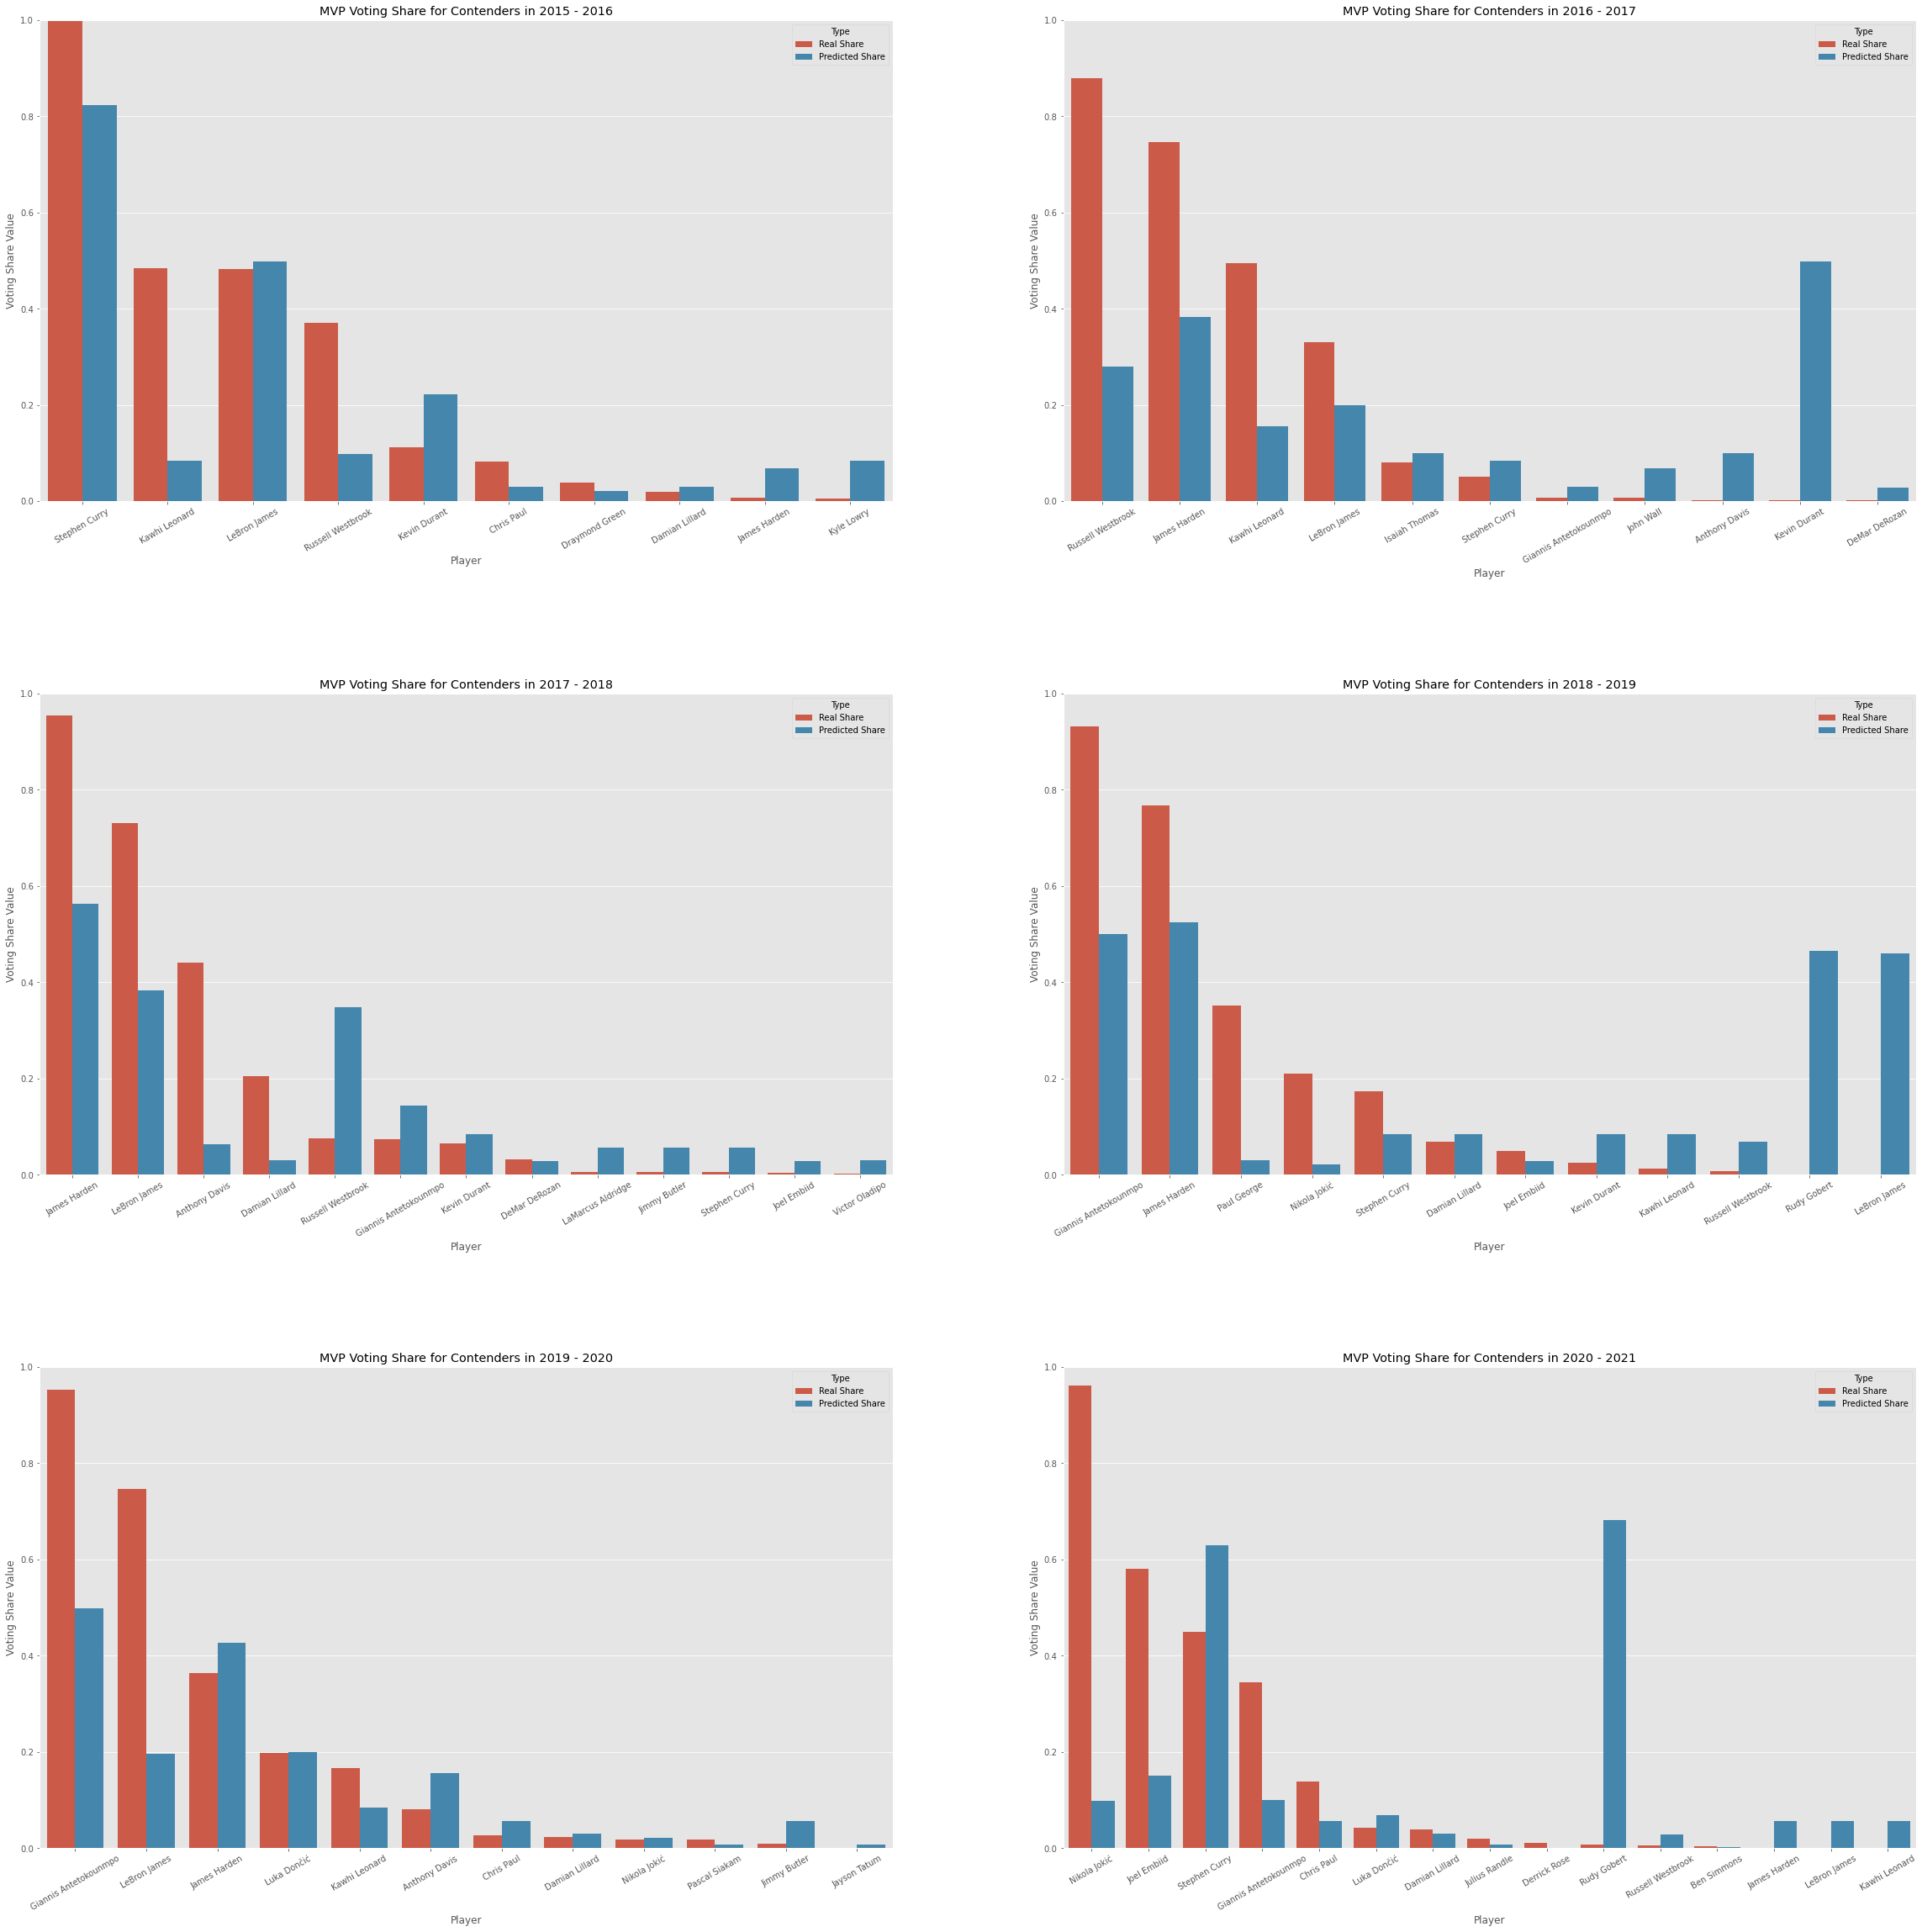

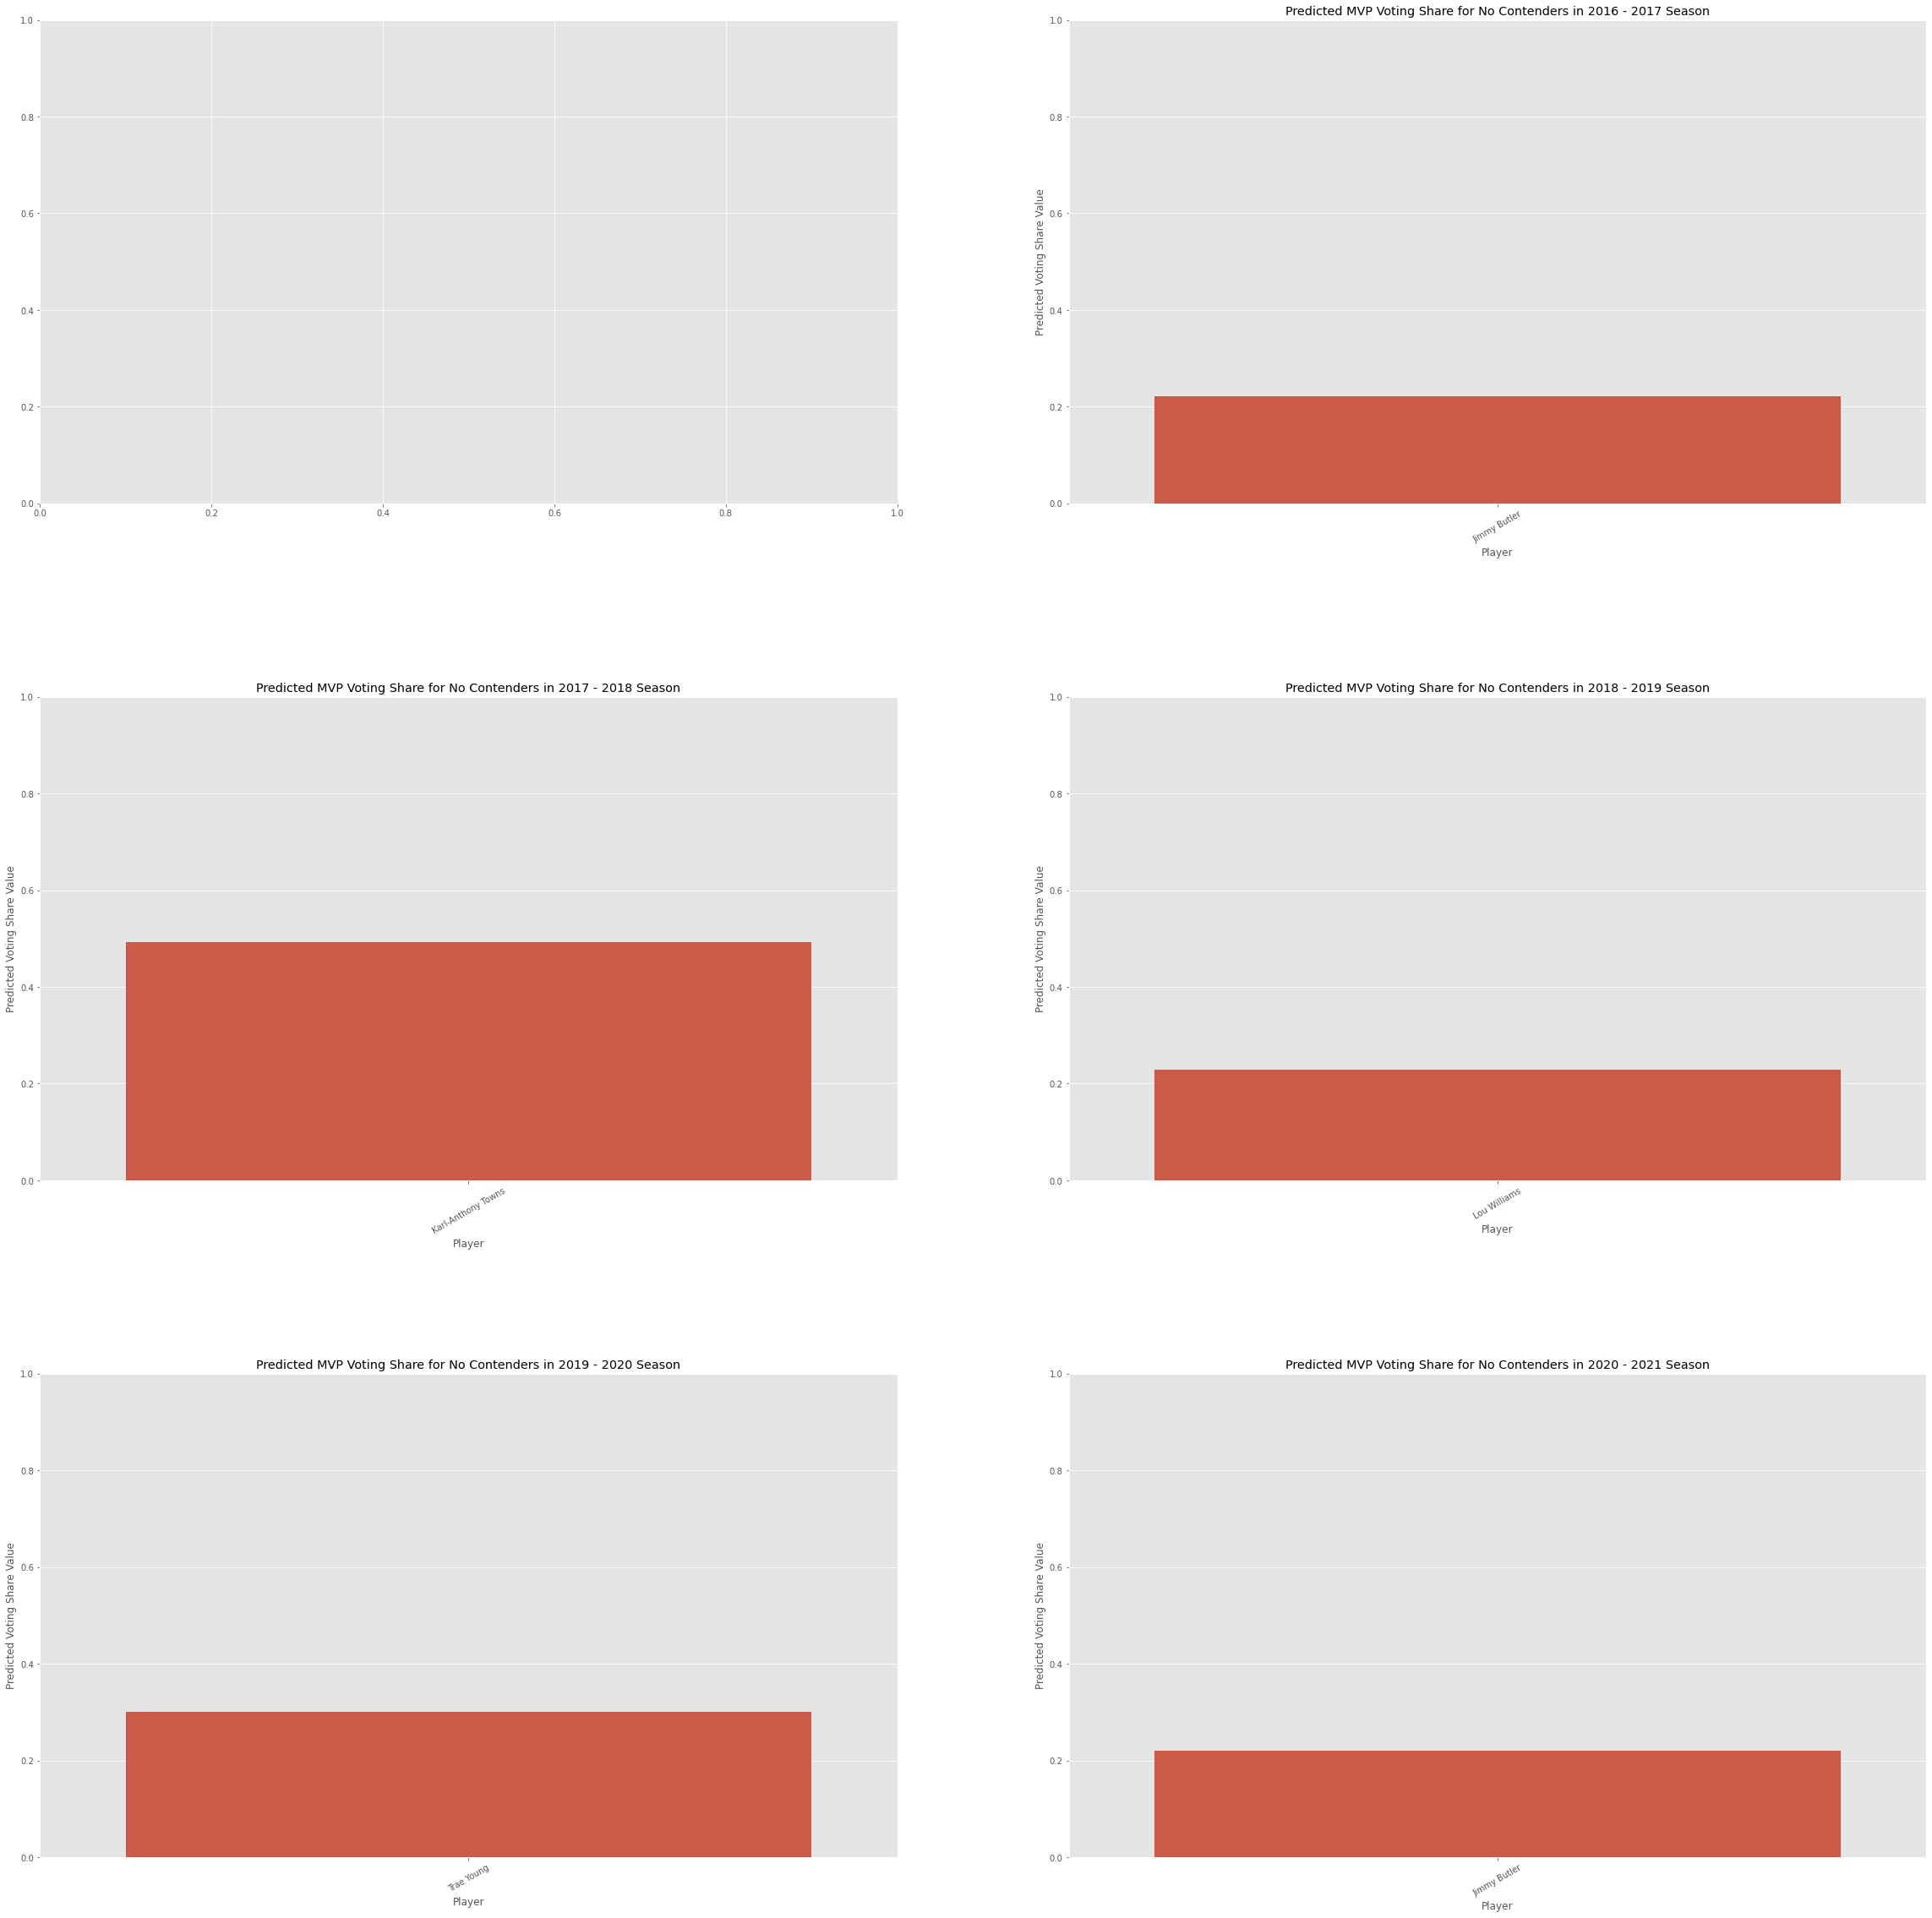

In [36]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)